# How ECG is analyzed in Neuroscience.
While there exist a number of really good solutions, so far the space of ECG features wasn't explored much. In this notebook, I will show you how to generate features from ECG channel with the help of 'neurokit2' python package

For a general overview, please see [this](https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/467129) Discussion post. Likewise, if you want to learn how to work with EEG, follow my earlier post [here](https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/466768).

In short, by the end of the notebook, you will learn that ECG is a special time-series data, and that you should work with it separately from other EEG channels. Most importantly you will learn how to extract R peaks, ECG-derived respiration and other neccessary cardiac features. Some of them are shown in a figure below:


<br>
P.S. If you computed all the neccessary features, you can get a score of 0.48 trained with Hist Gradient Boosting Classifier with data from ECG channel alone :)

Stay tuned for a similar tutorial on extracting relevant features from EEG.

<br>


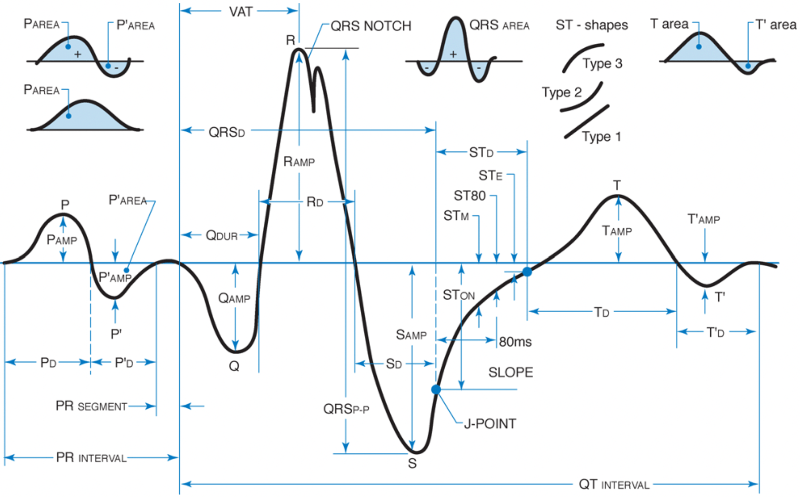


#### First things first, let's install neurokit2 and import necessary libraries

In [ ]:
%%capture
!pip install neurokit2;

In [ ]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import neurokit2 as nk

#### Let's import train EEG for just 1 exemplary subject

In [ ]:
fname = '/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/1002142157.parquet'
eeg = pd.read_parquet(fname)
ecg = eeg['EKG']

In [ ]:
# let's take first 10_000 timepoints, 
# which correspond to 50s of recording
offset = 10_000
plt.plot(np.linspace(0,50,len(ecg[:offset])),ecg[:offset])

#### The signal is clearly too noisy to detect heart related activity, specifically there seem to be some high-frequency noise. Let's define filtering function, and focus on heart-plausible frequency band. 0.05 to 20 Hz should be a reasonable range, as heart doesn't beat faster than 20 times a second

In [ ]:
from scipy.signal import butter, lfilter, resample

def bandpass_filter(data, L_freq=0.05,H_freq=20, sampling_rate=200, downsample=None):
    """
    Apply filter and optionally downsample data
    
    Arguments
    -----------------------------------------------------
    data:          numpy array with your data
    L_cutoff:      float, lowest frequency in a bandpass
    H_cutoff:      float, highest frequency in a bandpass
    sampling_rate: int, in Hz
    downsample:    int, the number of points which should 
                   the resulting signal contain (i.e, if
                   data originally has 10_000 t-points at 
                   200 Hz, setting downsample=2_500 will
                   downsample the data to 50 Hz)
    
    Code adapted from @crdeott
    """
    
    # Some 
    data = np.nan_to_num(data,nan=0.0)
    
    nyquist = 0.5 * sampling_rate
    L_cutoff = L_freq / nyquist
    H_cutoff = H_freq / nyquist
    
    
    b, a = butter(4, [L_cutoff, H_cutoff], btype='bandpass', analog=False)
    filtered_data = lfilter(b, a, data, axis=0)
    # Downsample from 10_000 to 2_500, i.e.:
    # 200Hz to 50Hz
    if downsample:
        filtered_data = resample(filtered_data,downsample)
    return filtered_data

In [ ]:
ecg_filtered = bandpass_filter(ecg[:offset])

#### Now we see individual peaks in heart activity

In [ ]:
plt.plot(np.linspace(0,50,len(ecg_filtered)),ecg_filtered)

#### Feature # 1 R-peaks 
Let's try detecting R peaks with neurokit2

In [ ]:
_,info = nk.ecg_peaks(ecg_filtered, sampling_rate=200)

In [ ]:
info

In [ ]:
plt.plot(ecg_filtered)
rpeaks = info["ECG_R_Peaks"]
plt.plot(rpeaks, ecg_filtered[rpeaks], "x")

#### Feature # 2 Heart rate
The simplest thing we could do, is to compute the heart rate with R peaks

In [ ]:
print(f" Heart rate is {len(rpeaks)/50*60} BPM")

alternatively, we could use a method from neurokit2 to calculate heart-rate over time, and that should be another feature BTW :)

In [ ]:
heart_rate = nk.ecg_rate(rpeaks,sampling_rate=200)
plt.plot(heart_rate)
plt.ylabel('BPM')

#### Clean ECG

While our filtering might be sufficient for detecting the R-peaks, the data is definitely not clean enough for extracting other features from ECG, so that's what we are going to do now.

In [ ]:
# here we take original data, non-filtered ecg
ecg_cleaned = nk.ecg_clean(ecg[:offset],sampling_rate=200)

In [ ]:
# now, filtered ecg
ecg_filtered_cleaned = nk.ecg_clean(ecg_filtered,sampling_rate=200)

for comparison, let's plot 3 ECG next to each other

In [ ]:
fig,axs = plt.subplots(4,1,figsize=(15,20))

X = np.linspace(0,50,offset)

axs[0].plot(X,ecg[:offset])
axs[0].set_title('Raw ecg')

axs[1].plot(X,ecg_filtered)
axs[1].set_title('Filtered ecg')

axs[2].plot(X,ecg_cleaned)
axs[2].set_title('Cleaned ecg')


axs[3].plot(X,ecg_filtered_cleaned)
axs[3].set_title('Filtered + cleaned ecg')


In [ ]:
info = nk.signal_findpeaks(ecg[:offset])

#### Feature 3: Compute Phase

In [ ]:
info = nk.ecg_phase(ecg_cleaned, sampling_rate=200)
info

### And yeah, all those NaNs, are due to suboptimal signal quality

In [ ]:
plt.plot(info['ECG_Phase_Completion_Atrial'])

#### Feature 4: ECG-derived respiration (EDR)

In [ ]:
rpeaks, info = nk.ecg_peaks(ecg_filtered_cleaned, sampling_rate=200)
ecg_rate = nk.signal_rate(rpeaks, sampling_rate=200, desired_length=len(rpeaks))
ecg_rsp = nk.ecg_rsp(ecg_rate, sampling_rate=200)
plt.plot(X,ecg_rsp)

#### Conclusion

These were some of the features you can compute from ECG data, to try in you pipelines. Feel free to explore more at https://neuropsychology.github.io/NeuroKit/introduction.html
